# Three model types, several dataset versions, total_cases not a feature

In [1]:
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels as stats
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import theano 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import initializers
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, GRU
from keras import regularizers
%matplotlib inline
import myutil_all as myutil
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
import importlib
_ = importlib.reload(myutil)

## Get data and do preliminary preprocessing

In [3]:
dfx_train = myutil.get_indexed_dataset('data/dengue_features_train.csv')
dfy_train = myutil.get_indexed_dataset('data/dengue_labels_train.csv')
dfx_test = myutil.get_indexed_dataset('data/dengue_features_test.csv')
# combine training features with training labels for data exploration later on
dftrain = myutil.set_index(pd.merge(dfx_train, dfy_train))
# Will stack the train and test datasets to treat all NaN values together
# Need to add bogus total_cases column to test dataset so the files can be easily concatenated
# update total_cases = -1 to easily identify the records for later split data to original partitions
dfx_test['total_cases'] = -1
dfall = myutil.set_index(pd.concat((dftrain, dfx_test), axis=0))
dfall.sort_index(axis=0, inplace=True)
# drop unecessary columns and save column names
delcols = ['year','week_start_date','reanalysis_sat_precip_amt_mm','reanalysis_specific_humidity_g_per_kg']
dfall.drop(delcols, axis=1, inplace=True)
cols = dfall.columns
# remove NaNs
dfall = myutil.set_nan_to_week_mean(dfall.copy())

## One hot encode city and weekofyear

In [4]:
# split dataset and hot encode weekof year
dfall_copy = dfall.copy()
dfall_iq = dfall_copy[dfall_copy['city'] == 'iq']
dfall_sj = dfall_copy[dfall_copy['city'] == 'sj']
enc = OneHotEncoder(categorical_features=np.array([0]))
dset = dict()
dset['iq'] = enc.fit_transform(dfall_iq.iloc[:,1:].values).toarray()
dset['sj'] = enc.fit_transform(dfall_sj.iloc[:,1:].values).toarray()
dset['iq'].shape

(676, 72)

## Create several versions of the datasets

In [5]:
# for each city, create version of datasets with 1, 2, 3, and 4 shifts
for city in dset.keys():
    datashift = dict()
    for shift_no in range(1,5):
        datashift[shift_no] = myutil.shift(dset[city], shift_no)
        #print(city, shift_no)
        #print(datashift[shift_no].shape)
    dset[city] = datashift

# for each city, each shift, create version of the dataset different scaling
for city in dset.keys():
    for shift_no in dset[city].keys():
        vers = dict()
        # save original as 'raw'
        vers['raw'] = np.hstack((dset[city][shift_no][:,:-1], dset[city][shift_no][:,-1:]))
        # save scaled with minmax in range [0,1] as 'minmax1'
        scaler = MinMaxScaler(feature_range=(0,1))
        vers['minmax1'] = np.hstack((scaler.fit_transform(dset[city][shift_no][:,:-1]), dset[city][shift_no][:,-1:]))
        # save scaled with minmax in range [0,1] as 'minmax1'
        # isolate features, so scaling will only affect features
        scaler = MinMaxScaler(feature_range=(-1,1))
        vers['minmax2'] = np.hstack((scaler.fit_transform(dset[city][shift_no][:,:-1]), dset[city][shift_no][:,-1:]))
        dset[city][shift_no] = vers
        
# for each city, each shift, each version, create X_train, y_train, and X_test partitions
dataset = dict()
for city in dset.keys():
    for shift_no in dset[city].keys():
        for vers in dset[city][shift_no].keys():
            npdata = dset[city][shift_no][vers]
            partition = dict()
            partition['X_train'] = npdata[npdata[:,-1]>0][:,:-1]
            partition['y_train'] = npdata[npdata[:,-1]>0][:,-1:]
            partition['X_test']  = npdata[npdata[:,-1]<0][:,:-1]
            id = city + '_' + str(shift_no) + '_' + vers
            dataset[id] = partition

In [6]:
#for key in dataset.keys():
#    print(key[:2])

## Linear regression

In [17]:
best_score = dict()
best_score['iq'] = 0 
best_score['sj'] = 0 
best_result = dict()
for id in dataset.keys():
    
    myscore = dict()
    X_train_, X_valid_, y_train_, y_valid_ = train_test_split(dataset[id]['X_train'], dataset[id]['y_train'],\
                                                              test_size=.33, random_state=42)
    # Create linear regression object
    for i in range(0, 6):
        if i==0: 
            key = 'LinearRegression'
            regr = linear_model.LinearRegression()
        if i==1:
            key = 'Ridge'
            regr = linear_model.Ridge(alpha = .5)
        if i==2:
            key = 'RidgeCV'  
            regr = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0])
        if i==3:
            key = 'Lasso'
            regr = linear_model.Lasso(alpha = .1)
        if i==4:
            key = 'LassoLars'
            regr = linear_model.LassoLars(alpha = .1)
        if i==5:
            key = 'BayesianRidge'  
            regr = linear_model.BayesianRidge()

        # Train the model using the training sets
        regr.fit(X_train_, y_train_.ravel())

        y_hat = regr.predict(X_train_)
        y_hat[ y_hat < 0] = 0
        y_hat = np.around(y_hat).astype('int')
        y_pred = regr.predict(X_valid_)
        y_pred[ y_pred < 0] = 0
        y_pred = np.around(y_pred).astype('int')

        # scores are training mae, validation mae, variance
        mae_train = mean_absolute_error(y_train_, y_hat)
        mae_valid = mean_absolute_error(y_valid_, y_pred)
        r2        = r2_score(y_valid_, y_pred)

        if abs(r2) < 1:
            this_score = abs(r2/mae_valid)
            #this_score = mae_valid
        else: 
            this_score = 0
            
        if id[:2] == 'iq':
            if this_score > best_score['iq']:
                best_score['iq'] = this_score
                best_result['iq'] = (regr, id, key, mae_train, mae_valid, r2)
        else:
            if this_score > best_score['sj']:
                best_score['sj'] = this_score
                best_result['sj'] = (regr, id, key, mae_train, mae_valid, r2)

for city in best_result.keys():
    print('Best result for {}'.format(city))
    print('\tBest dataset: {}'.format(best_result[city][1]))
    print('\tBest model  : {}'.format(best_result[city][2]))
    print('\t\tMAE train : %.2f' % best_result[city][3])
    print('\t\tMAE valid : %.2f' % best_result[city][4])
    print('\t\tVariance  : %.2f' % best_result[city][5])


Best result for iq
	Best dataset: iq_3_minmax1
	Best model  : LinearRegression
		MAE train : 5.14
		MAE valid : 9.74
		Variance  : -0.13
Best result for sj
	Best dataset: sj_3_minmax1
	Best model  : BayesianRidge
		MAE train : 24.40
		MAE valid : 24.23
		Variance  : 0.10


## Decisition tree regressor

In [8]:
best_score = dict()
best_score['iq'] = 0 
best_score['sj'] = 0 
best_result = dict()
for id in dataset.keys():
    
    print(id)
    
    myscore = dict()
    X_train_, X_valid_, y_train_, y_valid_ = train_test_split(dataset[id]['X_train'], dataset[id]['y_train'],\
                                                              test_size=.33, random_state=42)
        
    #RandomForestRegressor(n_estimators=10, criterion=’mse’, max_depth=None, min_samples_split=2, 
    #                      min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, 
    #                      max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
    #                      bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, 
    #                      warm_start=False)
    
    #regr = RandomForestRegressor(n_estimators=30, max_depth=max_depth, criterion='mse', random_state=0,\
    #                            min_samples_leaf=1)
    
    #AdaBoostRegressor(base_estimator=None, n_estimators=150, learning_rate=1.0, loss=’linear’, random_state=None)
    
    regr = AdaBoostRegressor(RandomForestRegressor(max_depth=6), n_estimators=200, learning_rate=0.01, \
                             loss='exponential', random_state=42)
    
    regr.fit(X_train_, y_train_.ravel())

    y_hat = regr.predict(X_train_)
    y_hat[ y_hat < 0] = 0
    y_hat = np.around(y_hat).astype('int')
    y_pred = regr.predict(X_valid_)
    y_pred[ y_pred < 0] = 0
    y_pred = np.around(y_pred).astype('int')

    # scores are training mae, validation mae, variance
    mae_train = mean_absolute_error(y_train_, y_hat)
    mae_valid = mean_absolute_error(y_valid_, y_pred)
    r2        = r2_score(y_valid_, y_pred)

    this_score = abs(r2/mae_valid)
    if id[:2] == 'iq':
        if this_score > best_score['iq']:
            best_score['iq'] = this_score
            best_result['iq'] = (regr, id, mae_train, mae_valid, r2)
    else:
        if this_score > best_score['sj']:
            best_score['sj'] = this_score
            best_result['sj'] = (regr, id, mae_train, mae_valid, r2)
    
    #plt.scatter(y_valid, y_pred)
    
for city in best_result.keys():
    print('Best result for {}'.format(city))
    print('\tBest dataset: {}'.format(best_result[city][1]))
    #print('\tBest model  : {}'.format(best_result[city][2]))
    print('\t\tMAE train : %.2f' % best_result[city][2])
    print('\t\tMAE valid : %.2f' % best_result[city][3])
    print('\t\tVariance  : %.2f' % best_result[city][4])
    print('Feature Importances:')
    print(best_result[city][0].feature_importances_)
    

iq_1_raw
iq_1_minmax1
iq_1_minmax2
iq_2_raw
iq_2_minmax1
iq_2_minmax2
iq_3_raw
iq_3_minmax1
iq_3_minmax2
iq_4_raw
iq_4_minmax1
iq_4_minmax2
sj_1_raw
sj_1_minmax1
sj_1_minmax2
sj_2_raw
sj_2_minmax1
sj_2_minmax2
sj_3_raw
sj_3_minmax1
sj_3_minmax2
sj_4_raw
sj_4_minmax1
sj_4_minmax2
Best result for iq
	Best dataset: iq_1_minmax1
		MAE train : 4.14
		MAE valid : 7.52
		Variance  : 0.02
Feature Importances:
[  4.25099092e-02   1.36300479e-03   1.10688105e-02   4.10998387e-02
   2.15264339e-02   2.52720641e-03   5.58359283e-03   1.09119431e-02
   7.68978698e-05   9.39366276e-05   4.86018947e-05   3.73962641e-04
   2.59877854e-04   2.76939528e-05   4.14960595e-05   6.49340824e-05
   6.39243223e-05   7.01397967e-04   6.05761452e-05   8.22382234e-06
   1.06218354e-04   4.52078296e-05   4.91892198e-05   8.84066046e-05
   4.45668328e-06   5.14306050e-06   6.79469346e-05   1.04623951e-04
   1.52382309e-05   1.63042440e-06   7.00206872e-06   1.48864932e-05
   3.33729281e-05   2.22499728e-06   7.2384

iq_1_raw
iq_1_minmax1
iq_1_minmax2
iq_2_raw
iq_2_minmax1
iq_2_minmax2
iq_3_raw
iq_3_minmax1
iq_3_minmax2
iq_4_raw
iq_4_minmax1
iq_4_minmax2
sj_1_raw
sj_1_minmax1
sj_1_minmax2
sj_2_raw
sj_2_minmax1
sj_2_minmax2
sj_3_raw
sj_3_minmax1
sj_3_minmax2
sj_4_raw
sj_4_minmax1
sj_4_minmax2
Best result for iq
	Final loss train: 5.875830040011607
	Final loss valid: 7.3661287473780765
	Variance score: -0.13


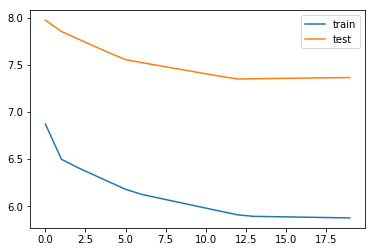

Best result for sj
	Final loss train: 25.56543864828817
	Final loss valid: 27.250637977829975
	Variance score: -0.19


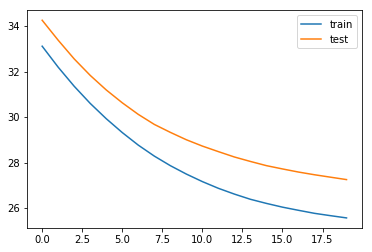

In [15]:
best_score = dict()
best_score['iq'] = 0 
best_score['sj'] = 0 
best_result = dict()
for id in dataset.keys():
    
    print(id)
    
    myscore = dict()
    X_train_, X_valid_, y_train_, y_valid_ = train_test_split(dataset[id]['X_train'], dataset[id]['y_train'],\
                                                              test_size=.33, random_state=42)
    
    X_train_ = X_train_.reshape(X_train_.shape[0], int(id[3:4]), int(X_train_.shape[1]/int(id[3:4])))
    X_valid_ = X_valid_.reshape(X_valid_.shape[0], int(id[3:4]), int(X_valid_.shape[1]/int(id[3:4])))
    
    # build graph
    regr = Sequential()
    
    #keras.layers.LSTM(units, activation='tanh', recurrent_activation='hard_sigmoid', 
    #              use_bias=True, kernel_initializer='glorot_uniform', 
    #              recurrent_initializer='orthogonal', bias_initializer='zeros', 
    #              unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, 
    #              bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
    #              recurrent_constraint=None, bias_constraint=None, dropout=0.0, 
    #              recurrent_dropout=0.0, implementation=1, return_sequences=False, 
    #              return_state=False, go_backwards=False, stateful=False, unroll=False)

    regr.add(GRU(X_train_.shape[2], input_shape=(X_train_.shape[1], X_train_.shape[2]),\
                  implementation=2, return_sequences=True))
    regr.add(GRU(10, return_sequences=True))
    regr.add(GRU(2))
    regr.add(Dense(1, kernel_regularizer=regularizers.l2(0.01), activation='linear'))
    regr.compile(loss='mae', optimizer='rmsprop')  # 'adam'
    
    # fit net
    history = regr.fit(X_train_, y_train_, epochs=20, batch_size=2,\
                       validation_data=(X_valid_, y_valid_), verbose=0, shuffle=False)
    
    y_hat = regr.predict(X_train_)
    y_hat[ y_hat < 0] = 0
    y_hat = np.around(y_hat).astype('int')
    y_pred = regr.predict(X_valid_)
    y_pred[ y_pred < 0] = 0
    y_pred = np.around(y_pred).astype('int')
    
    loss_train = history.history['loss'][-1]
    loss_valid = history.history['val_loss'][-1]
    r2 = r2_score(y_valid_, y_pred)

    if loss_valid > loss_train:
        #this_score = abs(r2/loss_valid)
        this_score = loss_valid
    else:
        this_score = 0
    
    if id[:2] == 'iq':
        if this_score > best_score['iq']:
            best_score['iq'] = this_score
            best_result['iq'] = (history.history, loss_train, loss_valid, r2)
    else:
        if this_score > best_score['sj']:
            best_score['sj'] = this_score
            best_result['sj'] = (history.history, loss_train, loss_valid, r2)
        
for city in best_result.keys():
    print('Best result for {}'.format(city))
    print('\tFinal loss train: {}'.format(best_result[city][1]))
    print('\tFinal loss valid: {}'.format(best_result[city][2]))
    print('\tVariance score: %.2f' % best_result[city][3])
    plt.plot(best_result[city][0]['loss'], label='train')
    plt.plot(best_result[city][0]['val_loss'], label='test')
    plt.legend()
    plt.show()
    